In [31]:
import sys
import os
from sciviso import *
from scproximite import *

# Set-up

### Load data and create visualisation Dataframe

In [32]:
data_dir = '../results/'

all_datasets = ['Discrete_Abundant','Discrete_Abundant_HVG2000','Discrete_Abundant_HVG500',
                          'Discrete_Rare','Discrete_Rare_HVG2000','Discrete_Rare_HVG500',
                          'Continuous_Abundant','Continuous_Abundant_HVG2000','Continuous_Abundant_HVG500',
                          'Continuous_Rare','Continuous_Rare_HVG2000','Continuous_Rare_HVG500']

datasets = dict.fromkeys(all_datasets, None) 

In [33]:
all_metrics = ['euclidean', 'cityblock', 'correlation', 'spearman', 'cosine', 'braycurtis', 'hamming', 'jaccard',
            'kulsinski', 'yule', 'OT', 'phi_s', 'weighted_rank', 'kendall', 'zi_kendall','canberra', 'chebyshev']

eval_metrics=['PSI']

k_vals = ["3K_stats", '10K_stats', "30K_stats", "50K_stats"]

for dataset in datasets.keys():
    datasets[dataset] = load_pickle(dataset, data_dir, mode='mean', metrics= all_metrics,eval_metrics=eval_metrics,k_vals=k_vals)

In [34]:
vis_df = vis_dataframe(datasets=all_datasets, datasets_dict=datasets, metrics=all_metrics, k_vals=k_vals, eval_metrics=eval_metrics)

#Create visualisation dataframe for supplementary Figure 11 (heatmap):
k30_df = vis_dataframe(datasets=all_datasets, datasets_dict=datasets, metrics=all_metrics, k_vals=['30K_stats'], eval_metrics=eval_metrics)

In [35]:
#Get the mean PSI for each metric, grouped by dataset across all k values:
mean_df = vis_df.groupby(['Metric','Dataset'])['Performance'].describe()
mean_df['ID'] = mean_df.index.map(lambda x: '_'.join([str(i) for i in x]))
dat = mean_df.reset_index()
dat = dat[['mean', 'ID']]

vis_df['ID'] = vis_df['Metric'].str.cat(vis_df[['Dataset']], sep='_')
vis_df = vis_df.merge(dat, how='inner', on='ID')

In [36]:
delta_df = vis_df.drop(labels = ['Performance','k_value','Evaluation_Metric',
                                 'Population_Balance'], axis = 1)
delta_df = delta_df.drop_duplicates(keep='first')

#Calculate difference in PSI between the dimensionality levels:
for index, row in delta_df.iterrows():
        met = row['Metric']
        con = row['Condition']
        Base = delta_df.query(f"Metric == '{met}' and Property=='Base' and Condition=='{con}'")
        HVG2000 = delta_df.query(f"Metric == '{met}' and Property=='HVG2000' and Condition=='{con}'")
        HVG500 = delta_df.query(f"Metric == '{met}' and Property=='HVG500' and Condition=='{con}'")
        delta_df.loc[index,'Base'] = Base['mean'].values
        delta_df.loc[index,'HVG2000']  = HVG2000['mean'].values
        delta_df.loc[index,'HVG500'] =  HVG500['mean'].values
        delta_df.loc[index,'Base to HVG500'] = HVG500['mean'].values - Base['mean'].values
        delta_df.loc[index,'Base to HVG2000'] = HVG2000['mean'].values - Base['mean'].values
        delta_df.loc[index,'HVG2000 to HVG500'] = HVG500['mean'].values - HVG2000['mean'].values

### Visualisation Aesthetics

In [37]:
figure_dir = ''

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 300

# Set to true if you want to save figures out:
save = False

#heatmap settings
heatmap_config = {
    'title_font_size': 15,
    'label_font_size': 12,
    'axis_font_size': 10,
    's': 60,
    'figsize': (15, 10),
}

#Seaborn theme and context:
sns.set_context("notebook")
sns.set_style("darkgrid",{'ytick.left': True,'xtick.bottom': True, 'axes.linewidth':1, 'axes.edgecolor':'black'})


#Colour dictionary for Metrics:
colour_dict = {'euclidean':'#393b79', 'cityblock':'#6b6ecf', 'correlation':'#637939', 'spearman':'#b5cf6b', 'cosine':'#e6550d',
          'braycurtis':'#843c39', 'hamming':'#d6616b', 'jaccard':'#31a354', 'kulsinski':'#7b4173', 'yule':'#ce6dbd',
          'OT':'#e7ba52', 'phi_s':'#3182bd','weighted_rank':'#e7969c', 'kendall':'#fdae6b', 'zi_kendall':'#9467bd',
          'canberra':'#8c6d31', 'chebyshev':'#636363'}

#Colour scale for heatmaps:
base_scale = 'viridis'

# Figure 5

In [38]:
fig5A_df = delta_df.copy(deep=True)

In [39]:
#Filter to only include metrics which show a >= change in PSI for one or both of the reduced dimension datasets relative to the HD.
for index, row in fig5A_df.iterrows():
    if row['Base to HVG500'] >=0.050 or row['Base to HVG2000'] >=0.050:
        fig5A_df.loc[index,'pass'] = True
    else:
        fig5A_df.loc[index,'pass']  = False
fig5A_df = fig5A_df[fig5A_df['pass'] == True]

In [40]:
import warnings
# Ignore setting with copy warning
warnings.simplefilter(action='ignore')

#Split vis dataframe by structural condition (e.g. Discrete Abundant):
adatas = [fig5A_df[fig5A_df['Condition'].isin([conditions])] for conditions in fig5A_df['Condition'].unique()]
new_adatas = []

for data in adatas:
    for index, row in data.iterrows():
        if row['Base to HVG500'] > row['Base to HVG2000']:
            data.loc[index,'Change'] = row['Base to HVG500']
        else:
            data.loc[index,'Change'] = row['Base to HVG2000']
    data = data.sort_values(by=['Change'], ascending=False) #sort dataframe from largest change in PSI to smallest
    data.reset_index(drop=True,inplace=True) #reset the index so it matches the new sort
    data = data[0:15] #Subset to only retain the top 5 metrics (accounting for duplicate rows for the 3 dimensionality levels).
    
    new_adatas.append(data)

In [41]:
filtered_data = pd.concat(new_adatas)
#Sort dataframe to ensure individual figure legends are correct:
filtered_data['Condition'] = pd.Categorical(filtered_data['Condition'], categories=['Discrete Abundant','Discrete Rare', 'Continuous Abundant', 'Continuous Rare'], ordered=True)
filtered_data = filtered_data.sort_values(['Metric','Condition']).reset_index(drop=True)

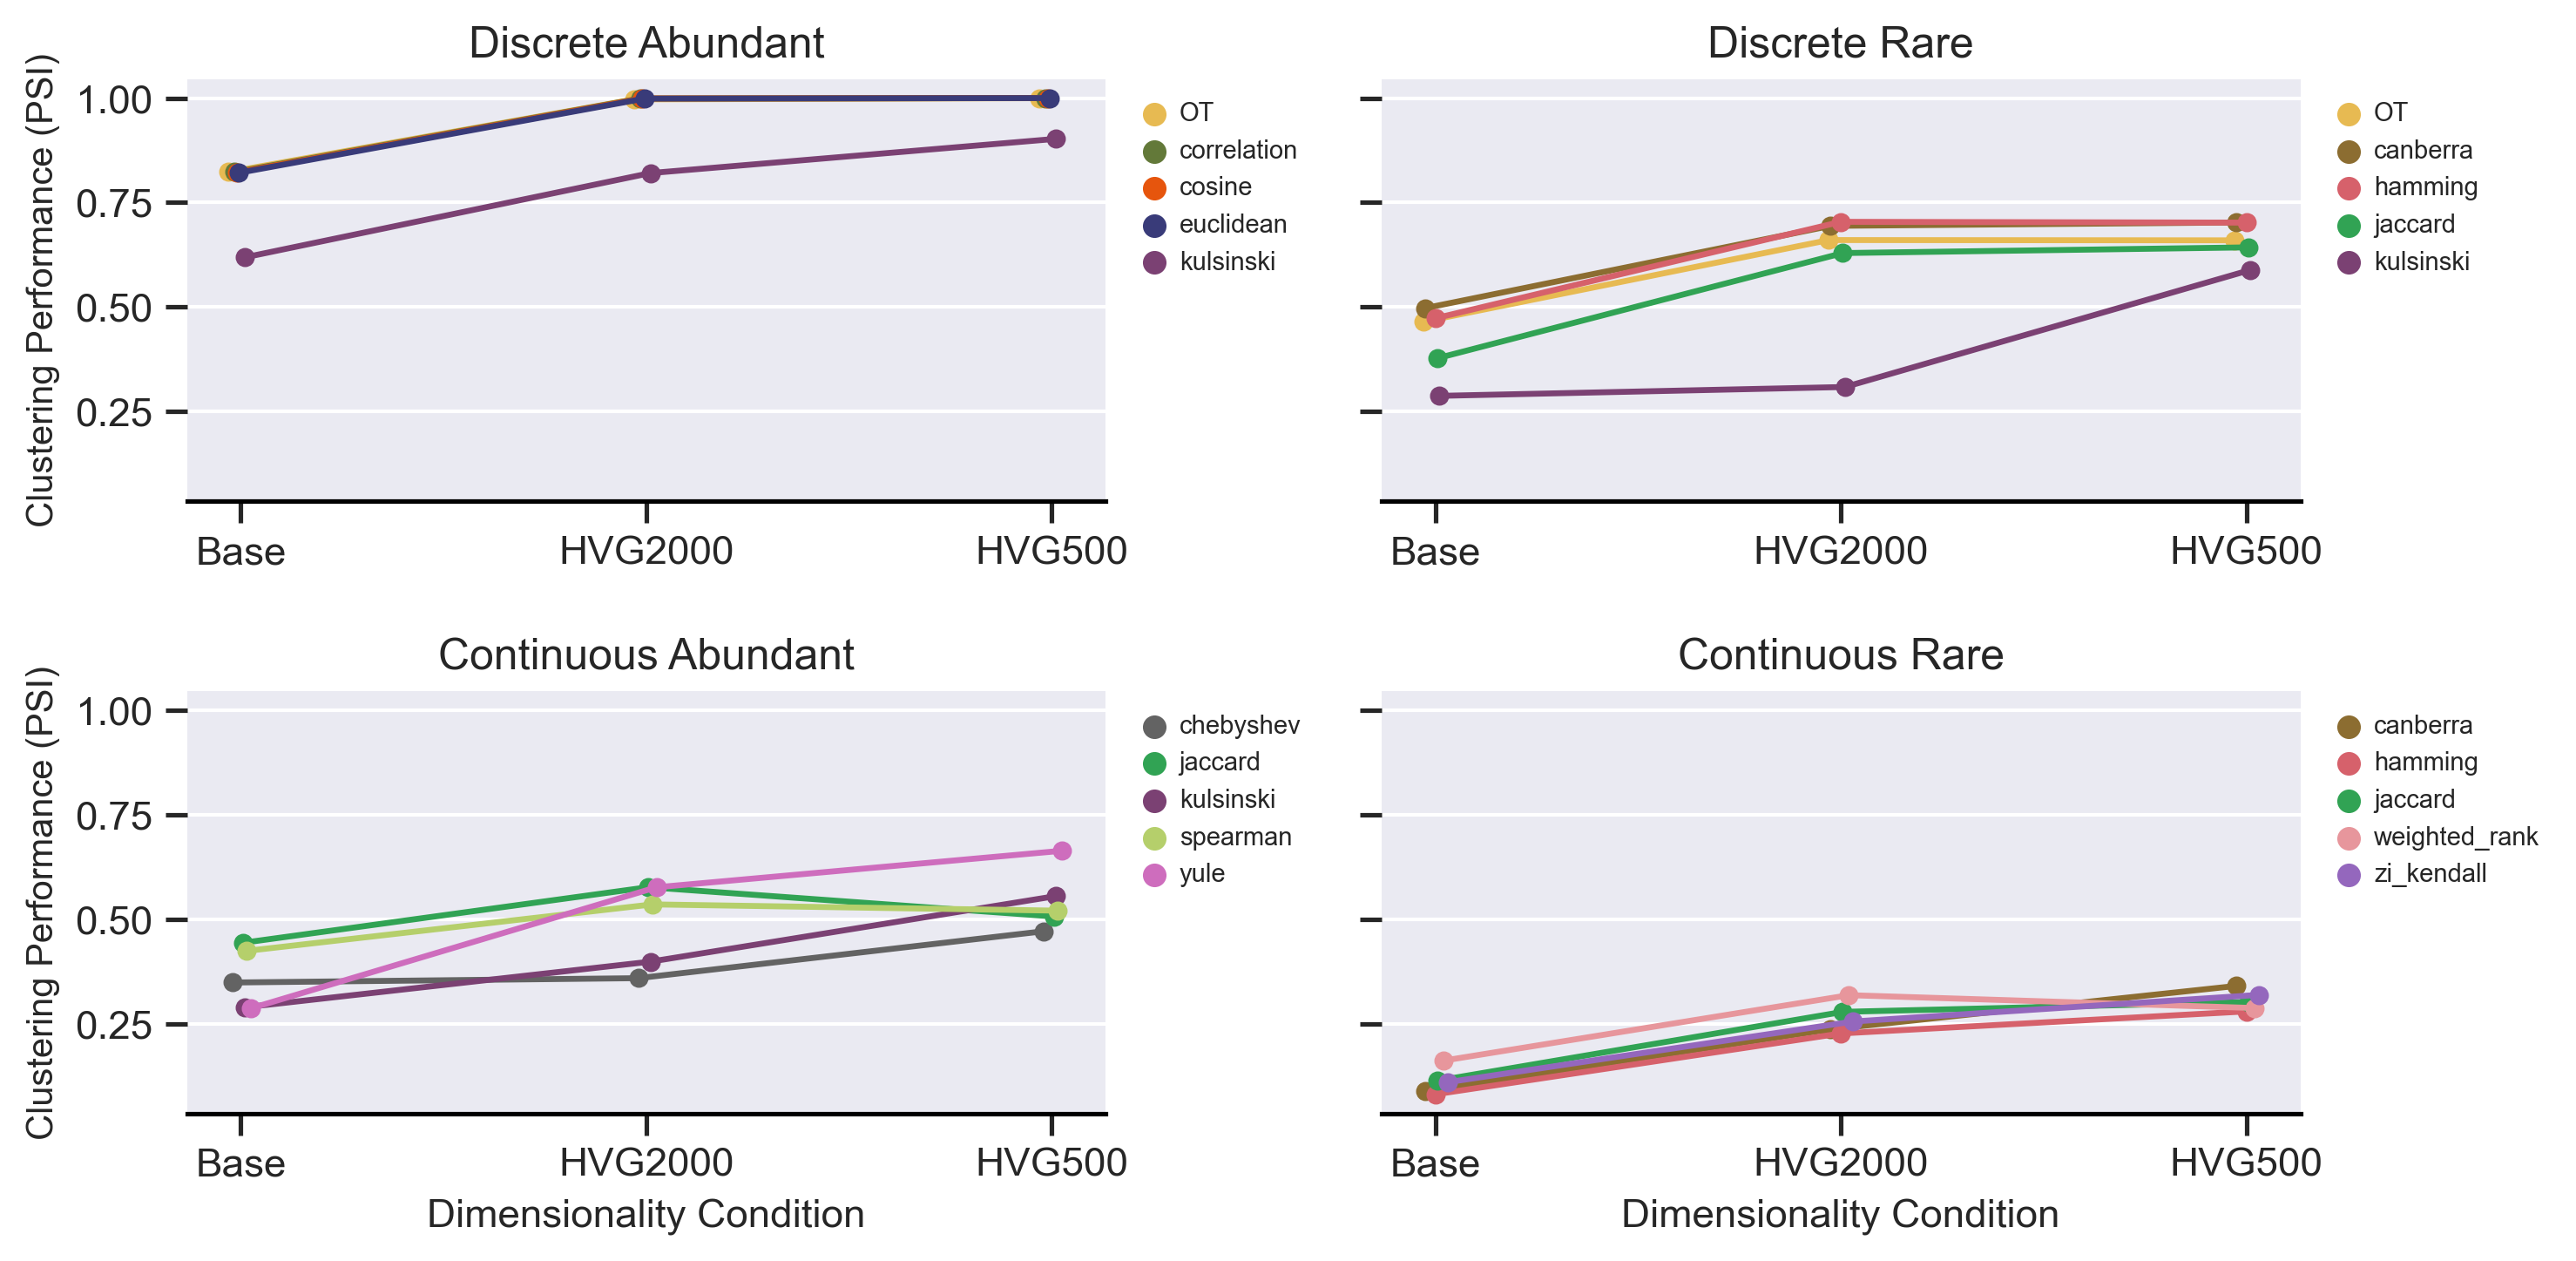

In [42]:
data = filtered_data

g = sns.catplot(x = 'Property',                  
                y = 'mean', 
                data = data,
                hue = 'Metric',
                style='Metric',
                col = 'Condition',
                col_order = ['Discrete Abundant','Discrete Rare', 'Continuous Abundant', 'Continuous Rare'],
                col_wrap = 2,
                palette = colour_dict,
                s=10,
                kind='point',
                join=True,
                order = ['Base', 'HVG2000', 'HVG500'],
                dodge=0.06,
                aspect = 1.8,
                sharey =True,
                height = 2.5,
                scale = 0.6,
                ci=None,
                legend_out = False).despine(left=True)


#### To produce individual legends for each subplot: ######

ser_vals = pd.Series(data['Metric'].sort_values().unique())

for axes, (i, d) in zip(g.axes.ravel(), data.groupby(['Condition'])):
    handles, labels = axes.get_legend_handles_labels()   
    #subplot aesthetics
    axes.margins(x=0.05)
    #axes.yaxis.set_tick_params(which='both', labelbottom=True)
    axes.xaxis.set_tick_params(which='both', labelbottom=True)
    
    vals = ser_vals[ser_vals.isin(d['Metric'].unique())]    
    idx = vals.index.tolist()
    
    if len(idx) > 0:
        axes.legend(handles = [handles[i] for i in idx], labels = vals.tolist(),bbox_to_anchor=(1, 1),
                    loc=2,prop={'size': 7},markerscale=1.3,facecolor='white',handletextpad=0,frameon=False)
############################################################

g.fig.subplots_adjust(wspace=0.3,hspace=0.45)
g.set_xlabels('Dimensionality Condition', fontsize=11)
g.set_ylabels('Clustering Performance (PSI)',fontsize=10)
g.set_titles(template='{col_name}')

if save is True:
    plt.savefig(f'{fig_dir}Figure_5A.svg', bbox_inches = 'tight')
    plt.savefig(f'{fig_dir}Figure_5A.png', bbox_inches = 'tight', dpi=300)

# Figure 5B

In [43]:
fig5B_df = delta_df.copy(deep=True)

In [44]:
#Filter to only include metrics which show an absolute change in PSI between the reduced dimension datasets of > 0.05:
for index, row in fig5B_df.iterrows():
    if abs(round(row['HVG2000 to HVG500'],2))>0.05:
        fig5B_df.loc[index,'pass'] = True
    else:
        fig5B_df.loc[index,'pass']  = False
fig5B_df = fig5B_df[fig5B_df['pass'] == True]

In [45]:
fig5B_df['Condition'] = pd.Categorical(fig5B_df['Condition'], categories=['Discrete Abundant','Discrete Rare', 'Continuous Abundant', 'Continuous Rare'], ordered=True)
fig5B_df = fig5B_df.sort_values(['Metric','Condition']).reset_index(drop=True)

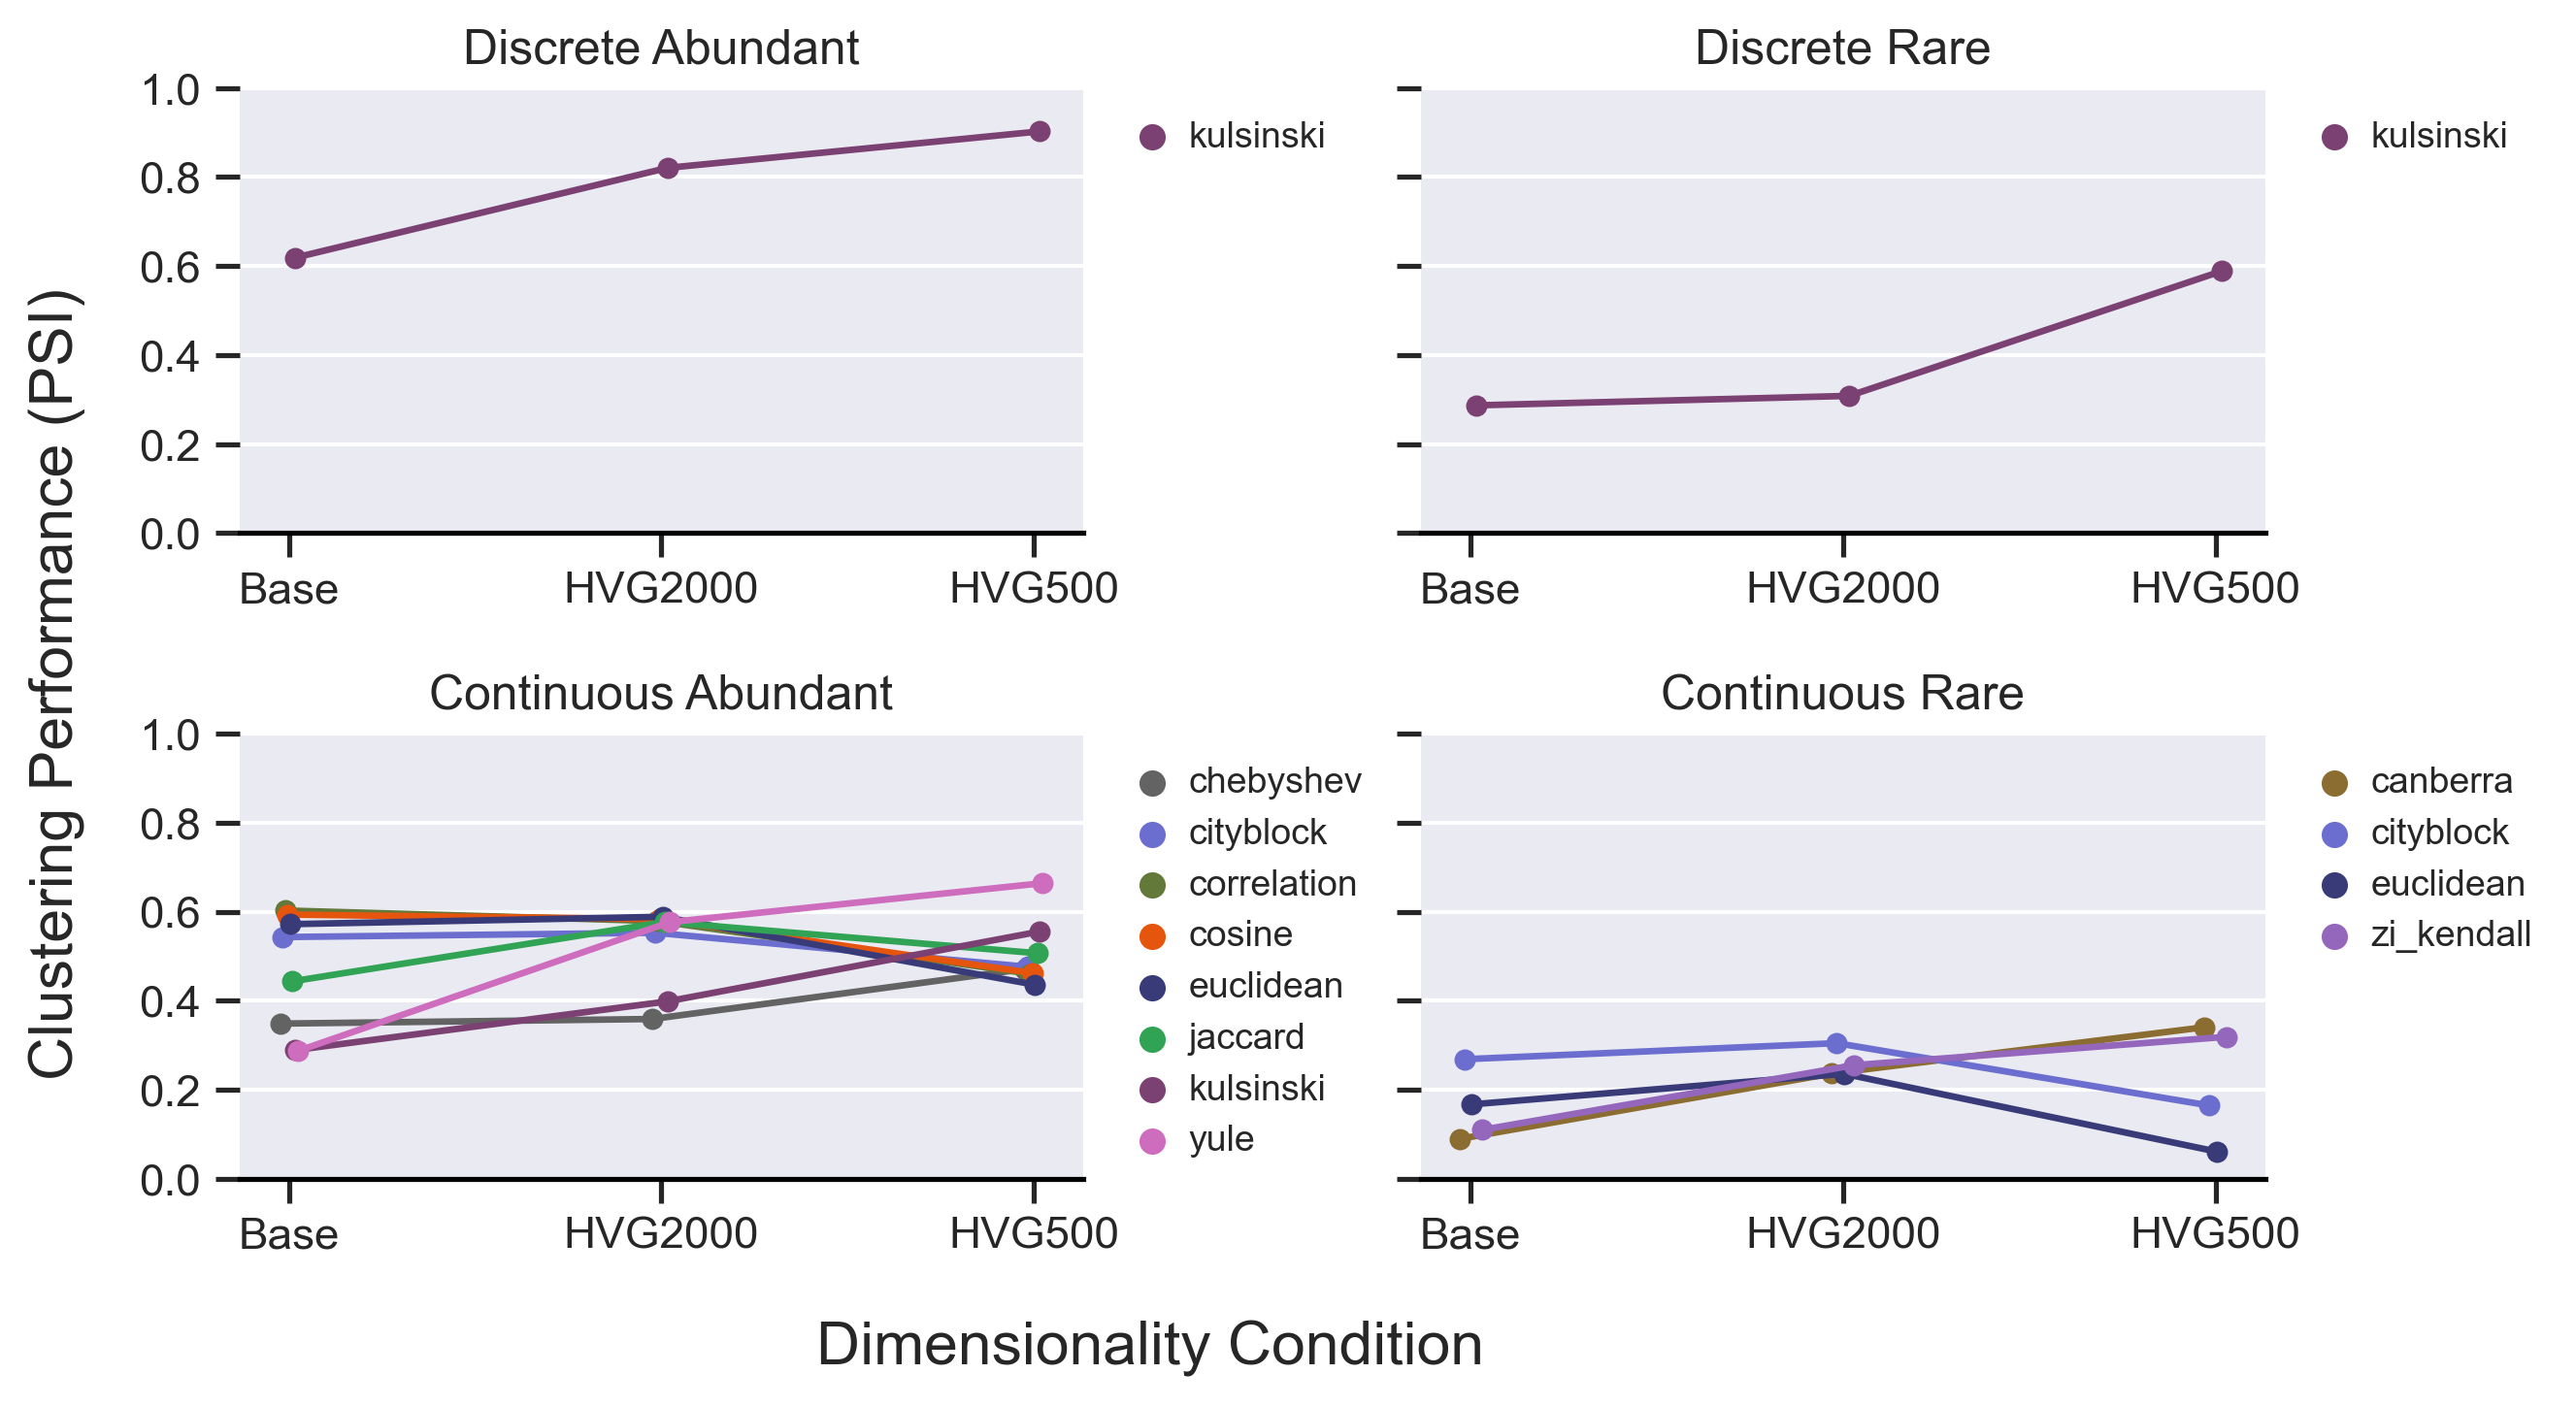

In [46]:
data = fig5B_df

g = sns.catplot(x = 'Property',                  
                y = 'mean', 
                data = data,
                hue = 'Metric',
                style='Metric',
                col = 'Condition',
                col_order = ['Discrete Abundant','Discrete Rare', 'Continuous Abundant', 'Continuous Rare'],
                col_wrap = 2,
                palette = colour_dict,
                s=10,
                kind='point',
                join=True,
                order = ['Base', 'HVG2000', 'HVG500'],
                dodge=0.06,
                aspect = 1.65,
                sharey = True,
                height = 2.43,
                scale = 0.6,
                ci=None,
                legend_out = False).despine(left=True)

ser_vals = pd.Series(data['Metric'].sort_values().unique())

for axes, (i, d) in zip(g.axes.ravel(), data.groupby(['Condition'])):
    handles, labels = axes.get_legend_handles_labels()
    
    axes.margins(x=0.05)
    #axes.yaxis.set_tick_params(which='both', labelbottom=True)
    axes.xaxis.set_tick_params(which='both', labelbottom=True)
    
    vals = ser_vals[ser_vals.isin(d['Metric'].unique())]    
    idx = vals.index.tolist()

    if len(idx) > 0:
        axes.legend(handles = [handles[i] for i in idx], labels = vals.tolist(), loc=2,
                    bbox_to_anchor=(1, 1),prop={'size': 9}, markerscale=1.3,
                    facecolor='white',handletextpad=0, frameon=False)

g.fig.subplots_adjust(left=0.11, bottom = 0.15, wspace=0.4,hspace=0.45)
g.set_ylabels('')
g.set_xlabels(' ')
g.set_titles(template='{col_name}')

g.fig.supxlabel('Dimensionality Condition',fontsize=15)
g.fig.supylabel('Clustering Performance (PSI)', fontsize=15)

g.set(ylim=(0, 1))

if save is True:
    plt.savefig(f'{fig_dir}Figure_5B.svg',  bbox_inches = 'tight')
    plt.savefig(f'{fig_dir}Figure_5B.png',  bbox_inches = 'tight', dpi=300)

# Supplementary Figure 4

In [47]:
vis_df['Condition'] = pd.Categorical(vis_df['Condition'], categories=['Discrete Abundant','Discrete Rare', 'Continuous Abundant', 'Continuous Rare'], ordered=True)
vis_df = vis_df.sort_values(['Metric','Condition']).reset_index(drop=True)

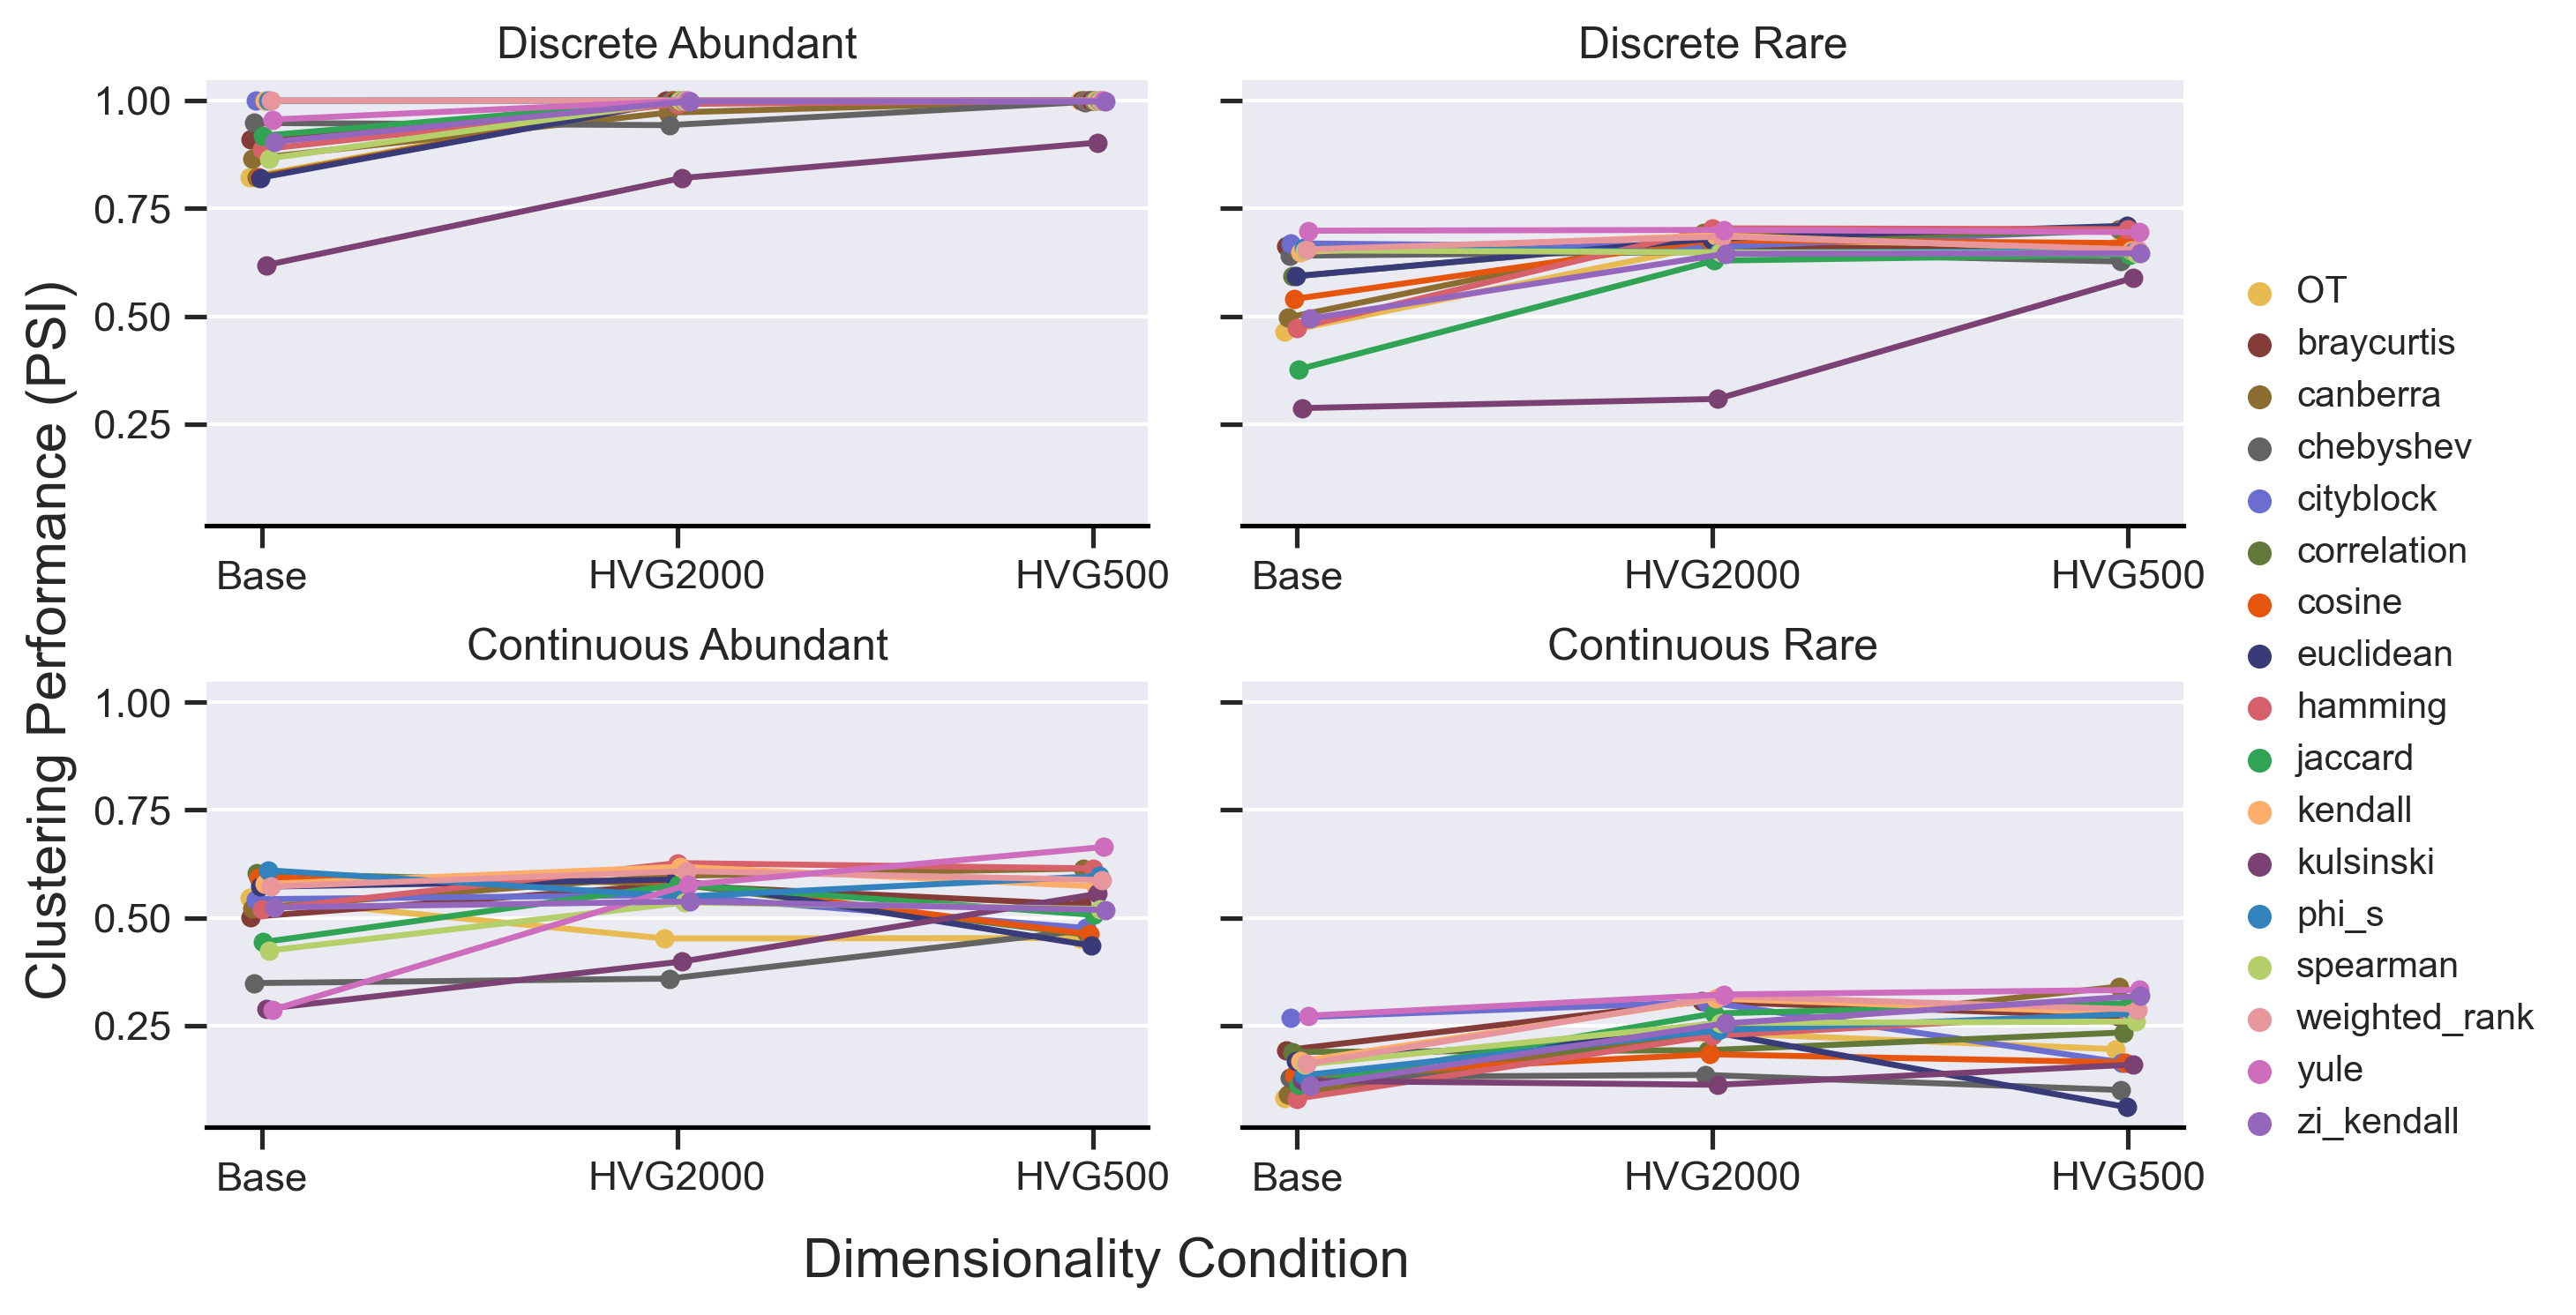

In [48]:
data = vis_df

g = sns.catplot(x = 'Property',                  
                y = 'mean', 
                data = data,
                hue = 'Metric',
                style='Metric',
                col = 'Condition',
                col_order = ['Discrete Abundant','Discrete Rare', 'Continuous Abundant', 'Continuous Rare'],
                col_wrap = 2,
                palette = colour_dict,
                s=10,
                kind='point',
                join=True,
                order = ['Base', 'HVG2000', 'HVG500'],
                dodge=0.06,
                aspect = 1.7,
                sharey = True,
                height = 2.5,
                scale = 0.6,
                ci=None,
                legend=False,
                legend_out = False).despine(left=True)


for axes, (i, d) in zip(g.axes.ravel(), data.groupby(['Condition'])):
    handles, labels = axes.get_legend_handles_labels()
    
    axes.margins(x=0.05)
    #axes.yaxis.set_tick_params(which='both', labelbottom=True)
    axes.xaxis.set_tick_params(which='both', labelbottom=True)
    
g.fig.legend(handles = handles, bbox_to_anchor=(1.15,0.8),
                    prop={'size': 10},markerscale=1.3,facecolor='white',handletextpad=0,frameon=False)

g.fig.subplots_adjust(left=0.1,wspace=0.1,hspace=0.35) 
g.set_ylabels('')
g.set_xlabels(' ')
g.set_titles(template='{col_name}')

g.fig.supxlabel('Dimensionality Condition',fontsize=15)
g.fig.supylabel('Clustering Performance (PSI)', fontsize=15)

if save is True:
    plt.savefig(f'{fig_dir}Figure_Sup4.svg',  bbox_inches = 'tight')
    plt.savefig(f'{fig_dir}Figure_Sup4.png',  bbox_inches = 'tight', dpi=300)

# Supplementary Figure 5

In [49]:
figSup5_df = delta_df.copy(deep=True)

In [50]:
#Filter to only include metrics which show an absolute change in PSI between the reduced dimension datasets of > 0.1:
for index, row in figSup5_df.iterrows():
    if row['Base to HVG500'] >0.10 or row['Base to HVG2000'] >0.10:
        figSup5_df.loc[index,'pass'] = True
    else:
        figSup5_df.loc[index,'pass']  = False
figSup5_df = figSup5_df[figSup5_df['pass'] == True]

In [51]:
figSup5_df['Condition'] = pd.Categorical(figSup5_df['Condition'], categories=['Discrete Abundant','Discrete Rare', 'Continuous Abundant', 'Continuous Rare'], ordered=True)
figSup5_df = figSup5_df.sort_values(['Metric','Condition']).reset_index(drop=True)

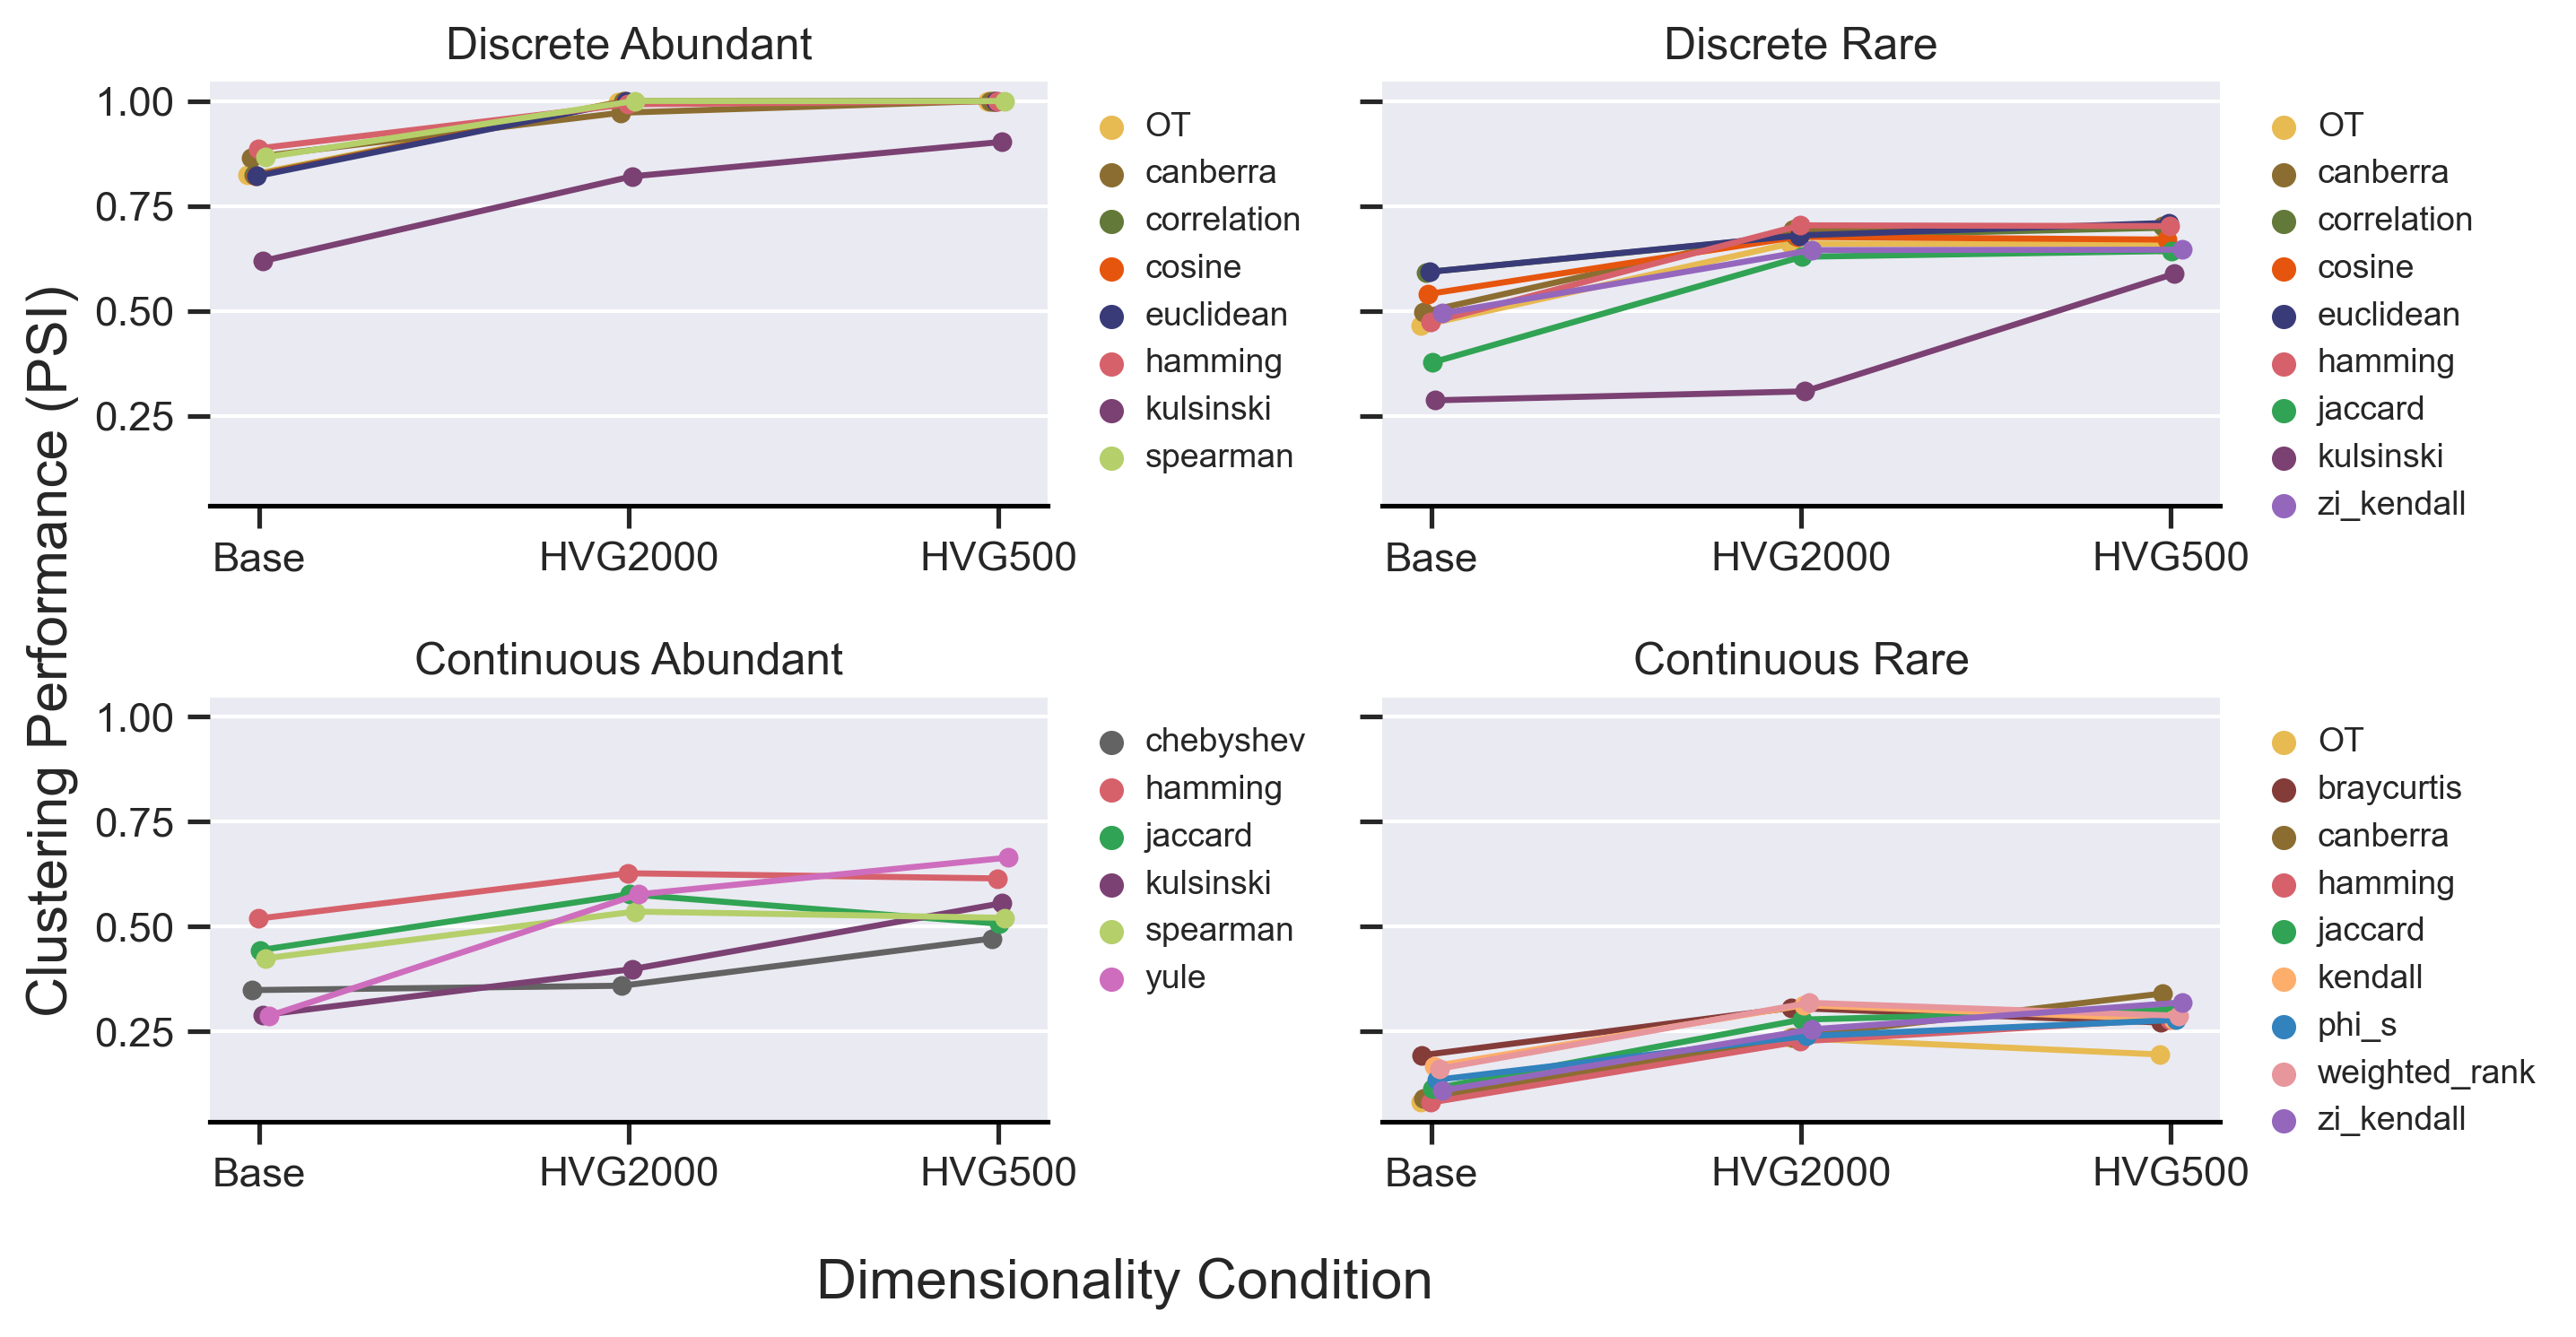

In [52]:
data = figSup5_df

g = sns.catplot(x = 'Property',                  
                y = 'mean', 
                data = data,
                hue = 'Metric',
                style='Metric',
                col = 'Condition',
                col_order = ['Discrete Abundant','Discrete Rare', 'Continuous Abundant', 'Continuous Rare'],
                col_wrap = 2,
                palette = colour_dict,
                s=10,
                kind='point',
                join=True,
                order = ['Base', 'HVG2000', 'HVG500'],
                dodge=0.06,
                aspect = 1.7,
                sharey = True,
                height = 2.5,
                scale = 0.6,
                ci=None,
                legend_out = False).despine(left=True)

ser_vals = pd.Series(data['Metric'].sort_values().unique())
for axes, (i, d) in zip(g.axes.ravel(), data.groupby(['Condition'])):
    handles, labels = axes.get_legend_handles_labels()

    axes.margins(x=0.05)
    #axes.yaxis.set_tick_params(which='both', labelbottom=True)
    axes.xaxis.set_tick_params(which='both', labelbottom=True)
    
    vals = ser_vals[ser_vals.isin(d['Metric'].unique())]    
    idx = vals.index.tolist()
    if len(idx) > 0:
        axes.legend(handles = [handles[i] for i in idx], labels = vals.tolist(), loc=2,
                    bbox_to_anchor=(1,1),prop={'size': 9}, markerscale=1.3,
                    facecolor='white',handletextpad=0, frameon=False)

g.fig.subplots_adjust(left=0.1, bottom = 0.15, wspace=0.4,hspace=0.45)

g.set_ylabels('')
g.set_xlabels(' ')
g.set_titles(template='{col_name}')

g.fig.supxlabel('Dimensionality Condition',fontsize=15)
g.fig.supylabel('Clustering Performance (PSI)', fontsize=15)

if save is True:
    plt.savefig(f'{fig_dir}Figure_Sup5.svg',  bbox_inches = 'tight')
    plt.savefig(f'{fig_dir}Figure_Sup5.png',  bbox_inches = 'tight', dpi=300)

# Supplementary Figure 6

In [53]:
figSup6_df = delta_df.copy(deep=True)

In [54]:
#Filter to only include metrics which have <0.05 change in PSI between all dimensionalities:
for index, row in figSup6_df.iterrows():
    if abs(row['Base to HVG500'])<0.050 and abs(row['Base to HVG2000'])<0.050 and abs(row['HVG2000 to HVG500'])<0.050:
        figSup6_df.loc[index,'pass'] = True
    else:
        figSup6_df.loc[index,'pass']  = False
figSup6_df = figSup6_df[figSup6_df['pass'] == True]

In [55]:
figSup6_df['Condition'] = pd.Categorical(figSup6_df['Condition'], categories=['Discrete Abundant','Discrete Rare', 'Continuous Abundant', 'Continuous Rare'], ordered=True)
figSup6_df = figSup6_df.sort_values(['Metric','Condition']).reset_index(drop=True)

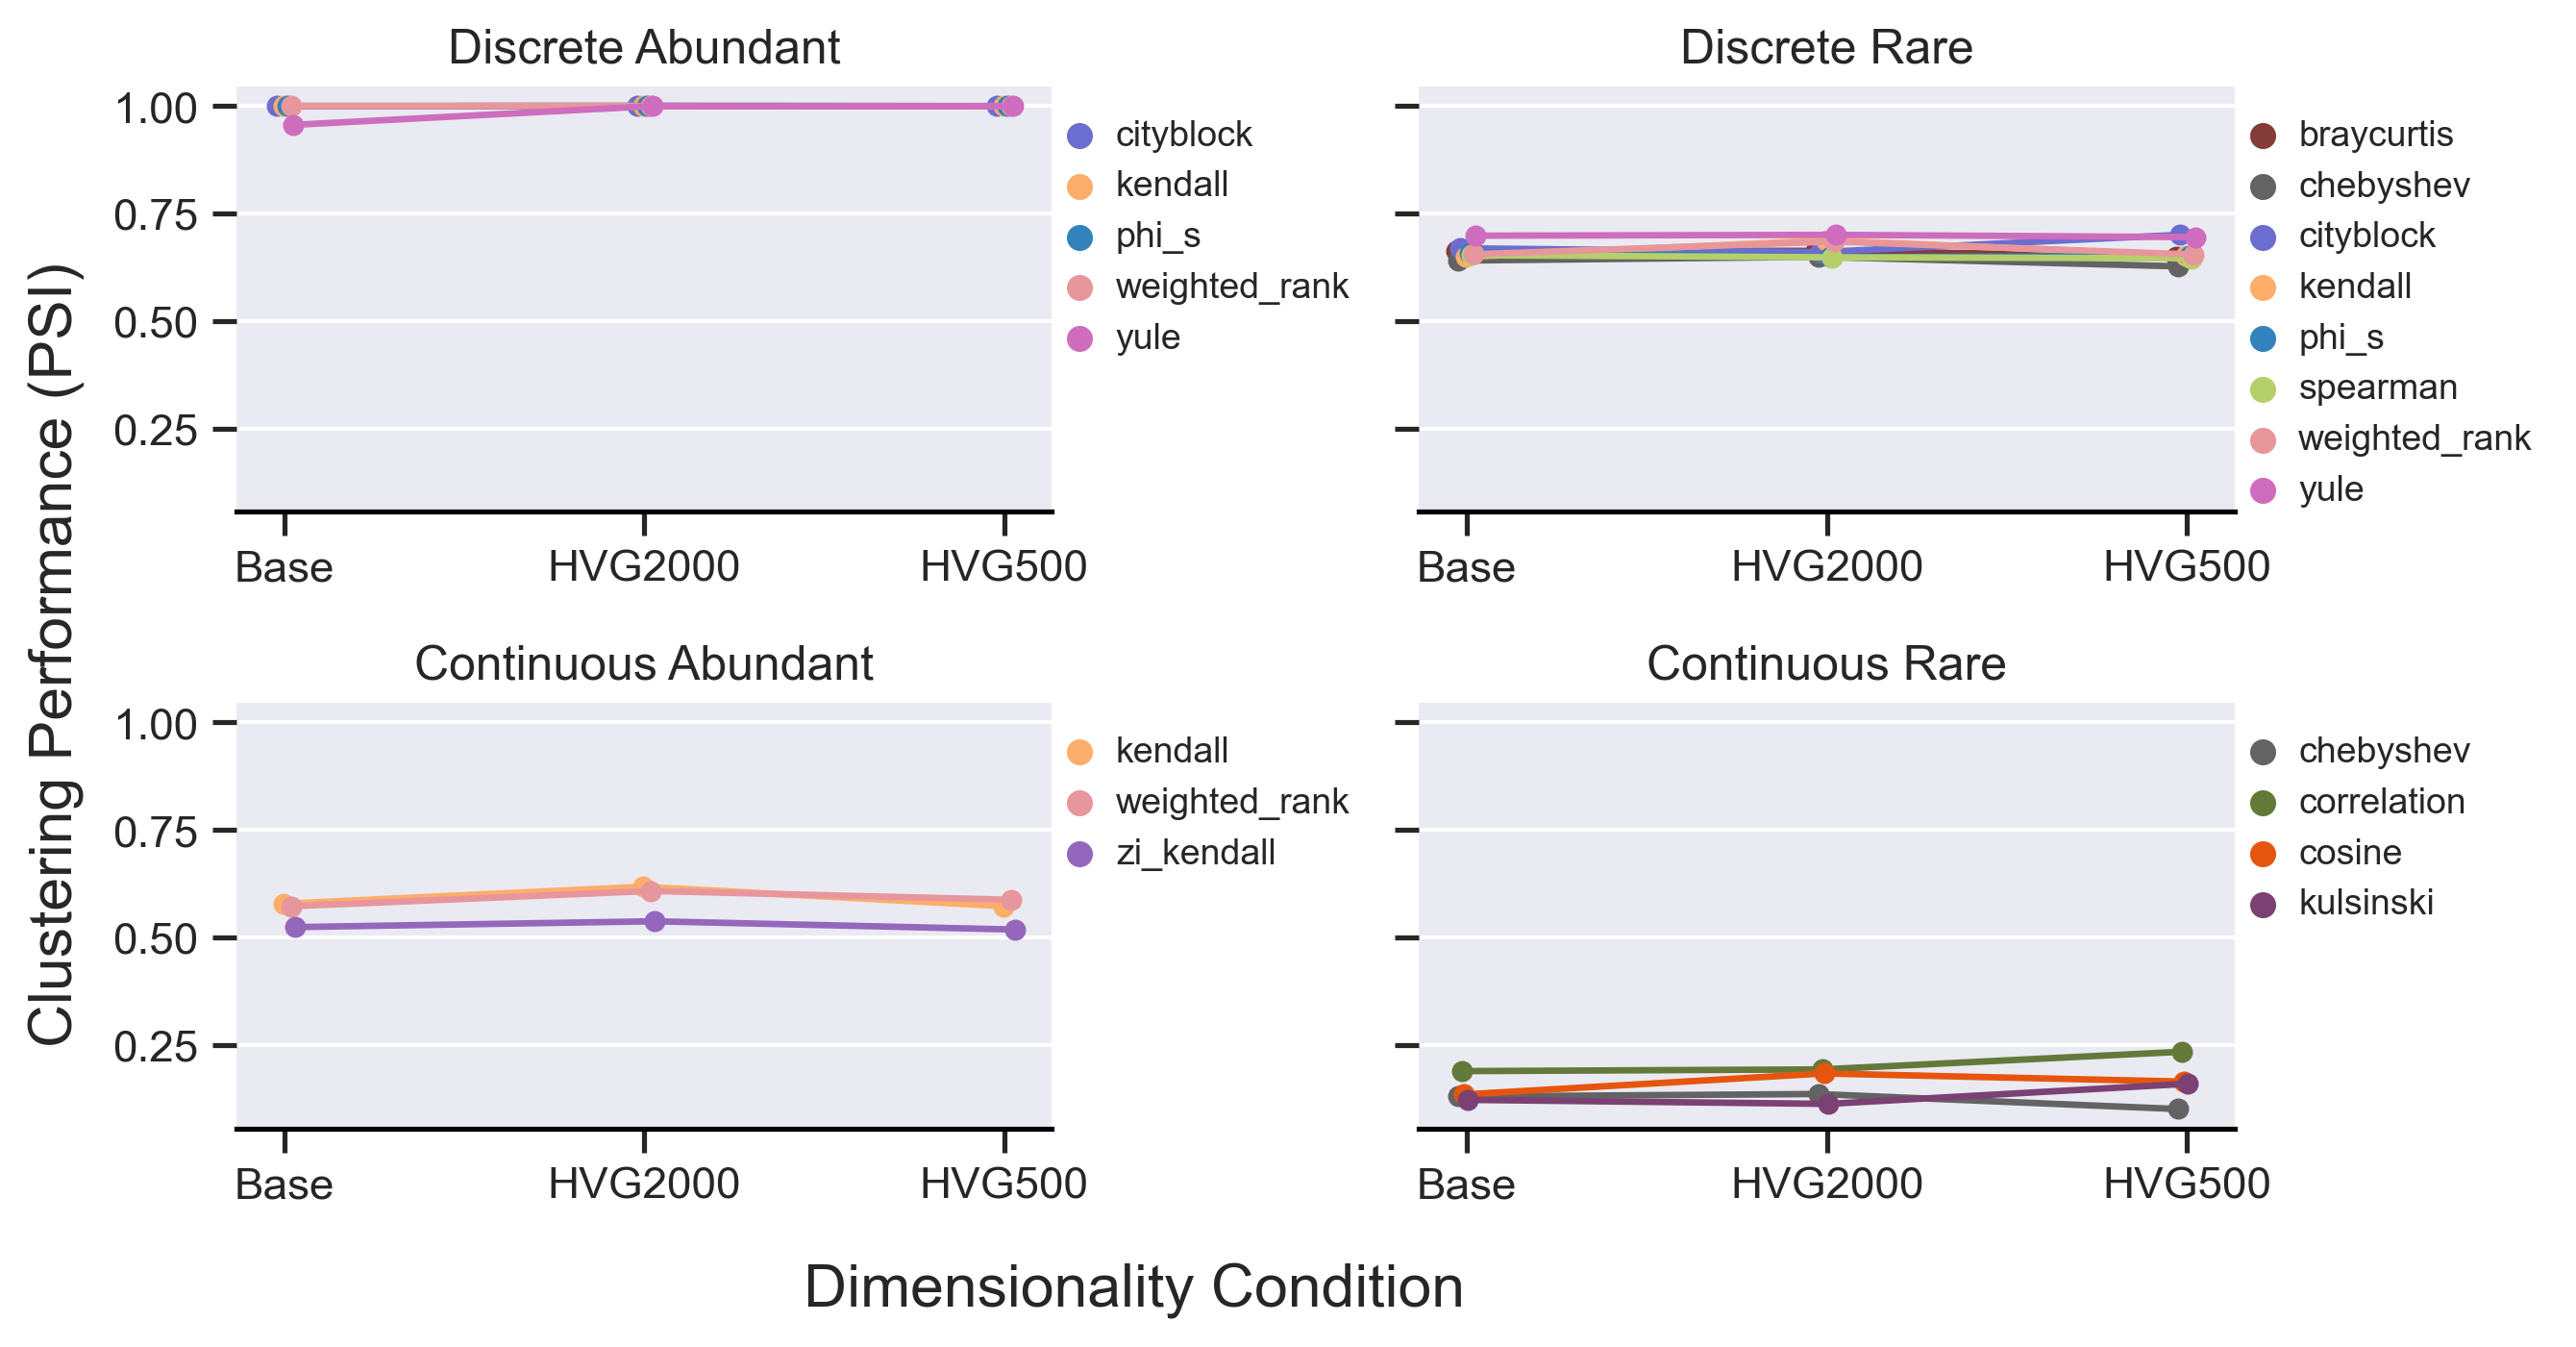

In [56]:
data = figSup6_df

g = sns.catplot(x = 'Property',                  
                y = 'mean', 
                data = data,
                hue = 'Metric',
                style='Metric',
                col = 'Condition',
                col_order = ['Discrete Abundant','Discrete Rare', 'Continuous Abundant', 'Continuous Rare'],
                col_wrap = 2,
                palette = colour_dict,
                s=10,
                kind='point',
                join=True,
                order = ['Base', 'HVG2000', 'HVG500'],
                dodge=0.06,
                aspect = 1.7,
                sharey = True,
                height = 2.35,
                scale = 0.6,
                ci=None,
                legend_out = False).despine(left=True)


ser_vals = pd.Series(data['Metric'].sort_values().unique())
for axes, (i, d) in zip(g.axes.ravel(), data.groupby(['Condition'])):
    handles, labels = axes.get_legend_handles_labels()

    axes.margins(x=0.05)
    #axes.yaxis.set_tick_params(which='both', labelbottom=True)
    axes.xaxis.set_tick_params(which='both', labelbottom=True)
    
    vals = ser_vals[ser_vals.isin(d['Metric'].unique())]    
    idx = vals.index.tolist()
    if len(idx) > 0:
        axes.legend(handles = [handles[i] for i in idx], labels = vals.tolist(),loc=2,
                bbox_to_anchor=(0.95, 1),prop={'size': 9}, markerscale=1.3,
                    facecolor='white',handletextpad=0, frameon = False)

g.fig.subplots_adjust(left=0.11, bottom = 0.15, wspace=0.45,hspace=0.45)

g.set_ylabels('')
g.set_xlabels(' ')
g.set_titles(template='{col_name}')

g.fig.supxlabel('Dimensionality Condition',fontsize=15)
g.fig.supylabel('Clustering Performance (PSI)', fontsize=15)

if save is True:
    plt.savefig(f'{fig_dir}Figure_Sup6.png',  bbox_inches = 'tight', dpi=300)
    plt.savefig(f'{fig_dir}Figure_Sup6.svg',  bbox_inches = 'tight')

# Heatmap Figures

## Figure 10 Panel B

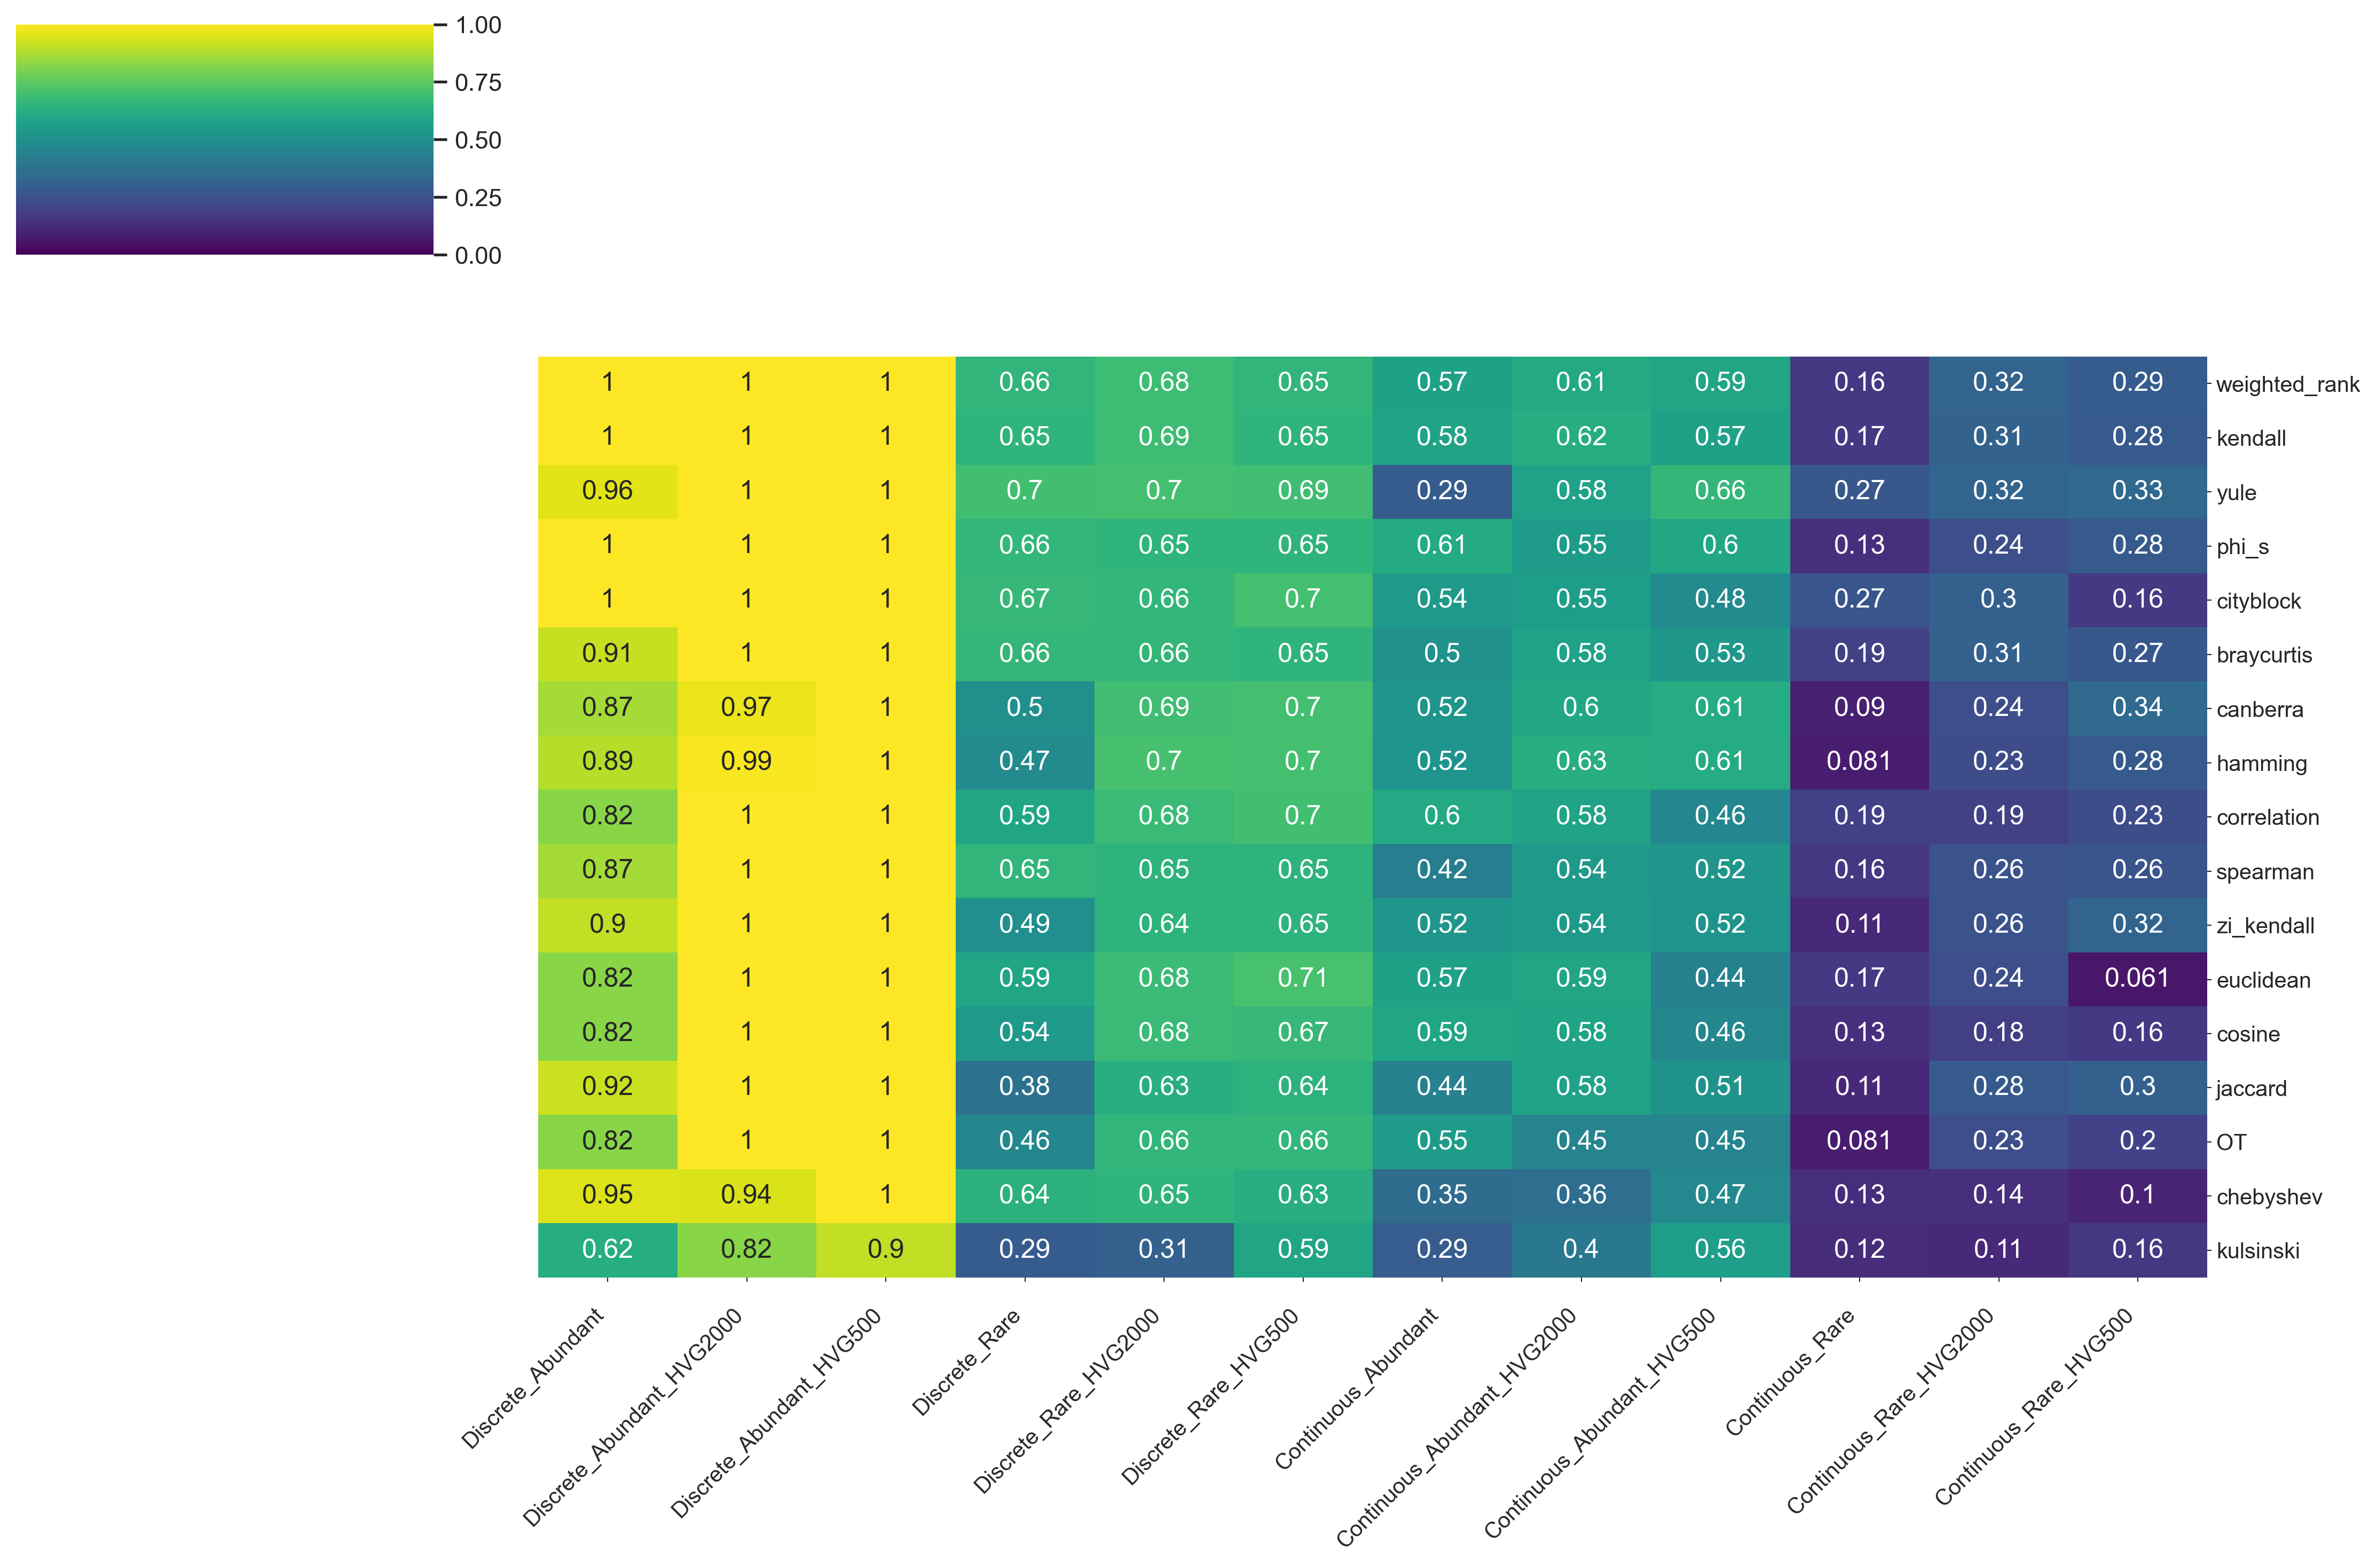

In [57]:
#Drop unnecessary columns & remove duplicates:
heat_df = vis_df.drop(labels = ['Performance','k_value','Evaluation_Metric',
                                 'Population_Balance', 'Data_Structure', 'Condition', 'ID', 'Property'], axis = 1)
heat_df = heat_df.drop_duplicates(keep='first').set_index('Metric')

#Reform dataframe:
heat_df = heat_df.pivot(columns='Dataset', values='mean').reindex(columns=all_datasets)

#Sort metrics by mean best performing across all datasets:
heat_df['metric_avg'] = np.mean(heat_df.values, axis=1)
heat_df = heat_df.sort_values(by=['metric_avg'], ascending=False)
heat_df['metric'] = heat_df.index

heatmap = Heatmap(heat_df,chart_columns=all_datasets,
                  row_index='metric',
                  cmap=base_scale, 
                  vmin=0, vmax=1, 
                  annot = True,
                  cluster_rows=False, cluster_cols=False, 
                 config=heatmap_config)
ax = heatmap.plot()
ax.ax_heatmap.tick_params(axis='x', which='major', pad=10)
if save is True:
    plt.savefig(f'{fig_dir}Figure_10B.svg',  bbox_inches = 'tight')
    plt.savefig(f'{fig_dir}Figure10B.png',  bbox_inches = 'tight', dpi=300)

## Supplementary Figure 11 Panel B

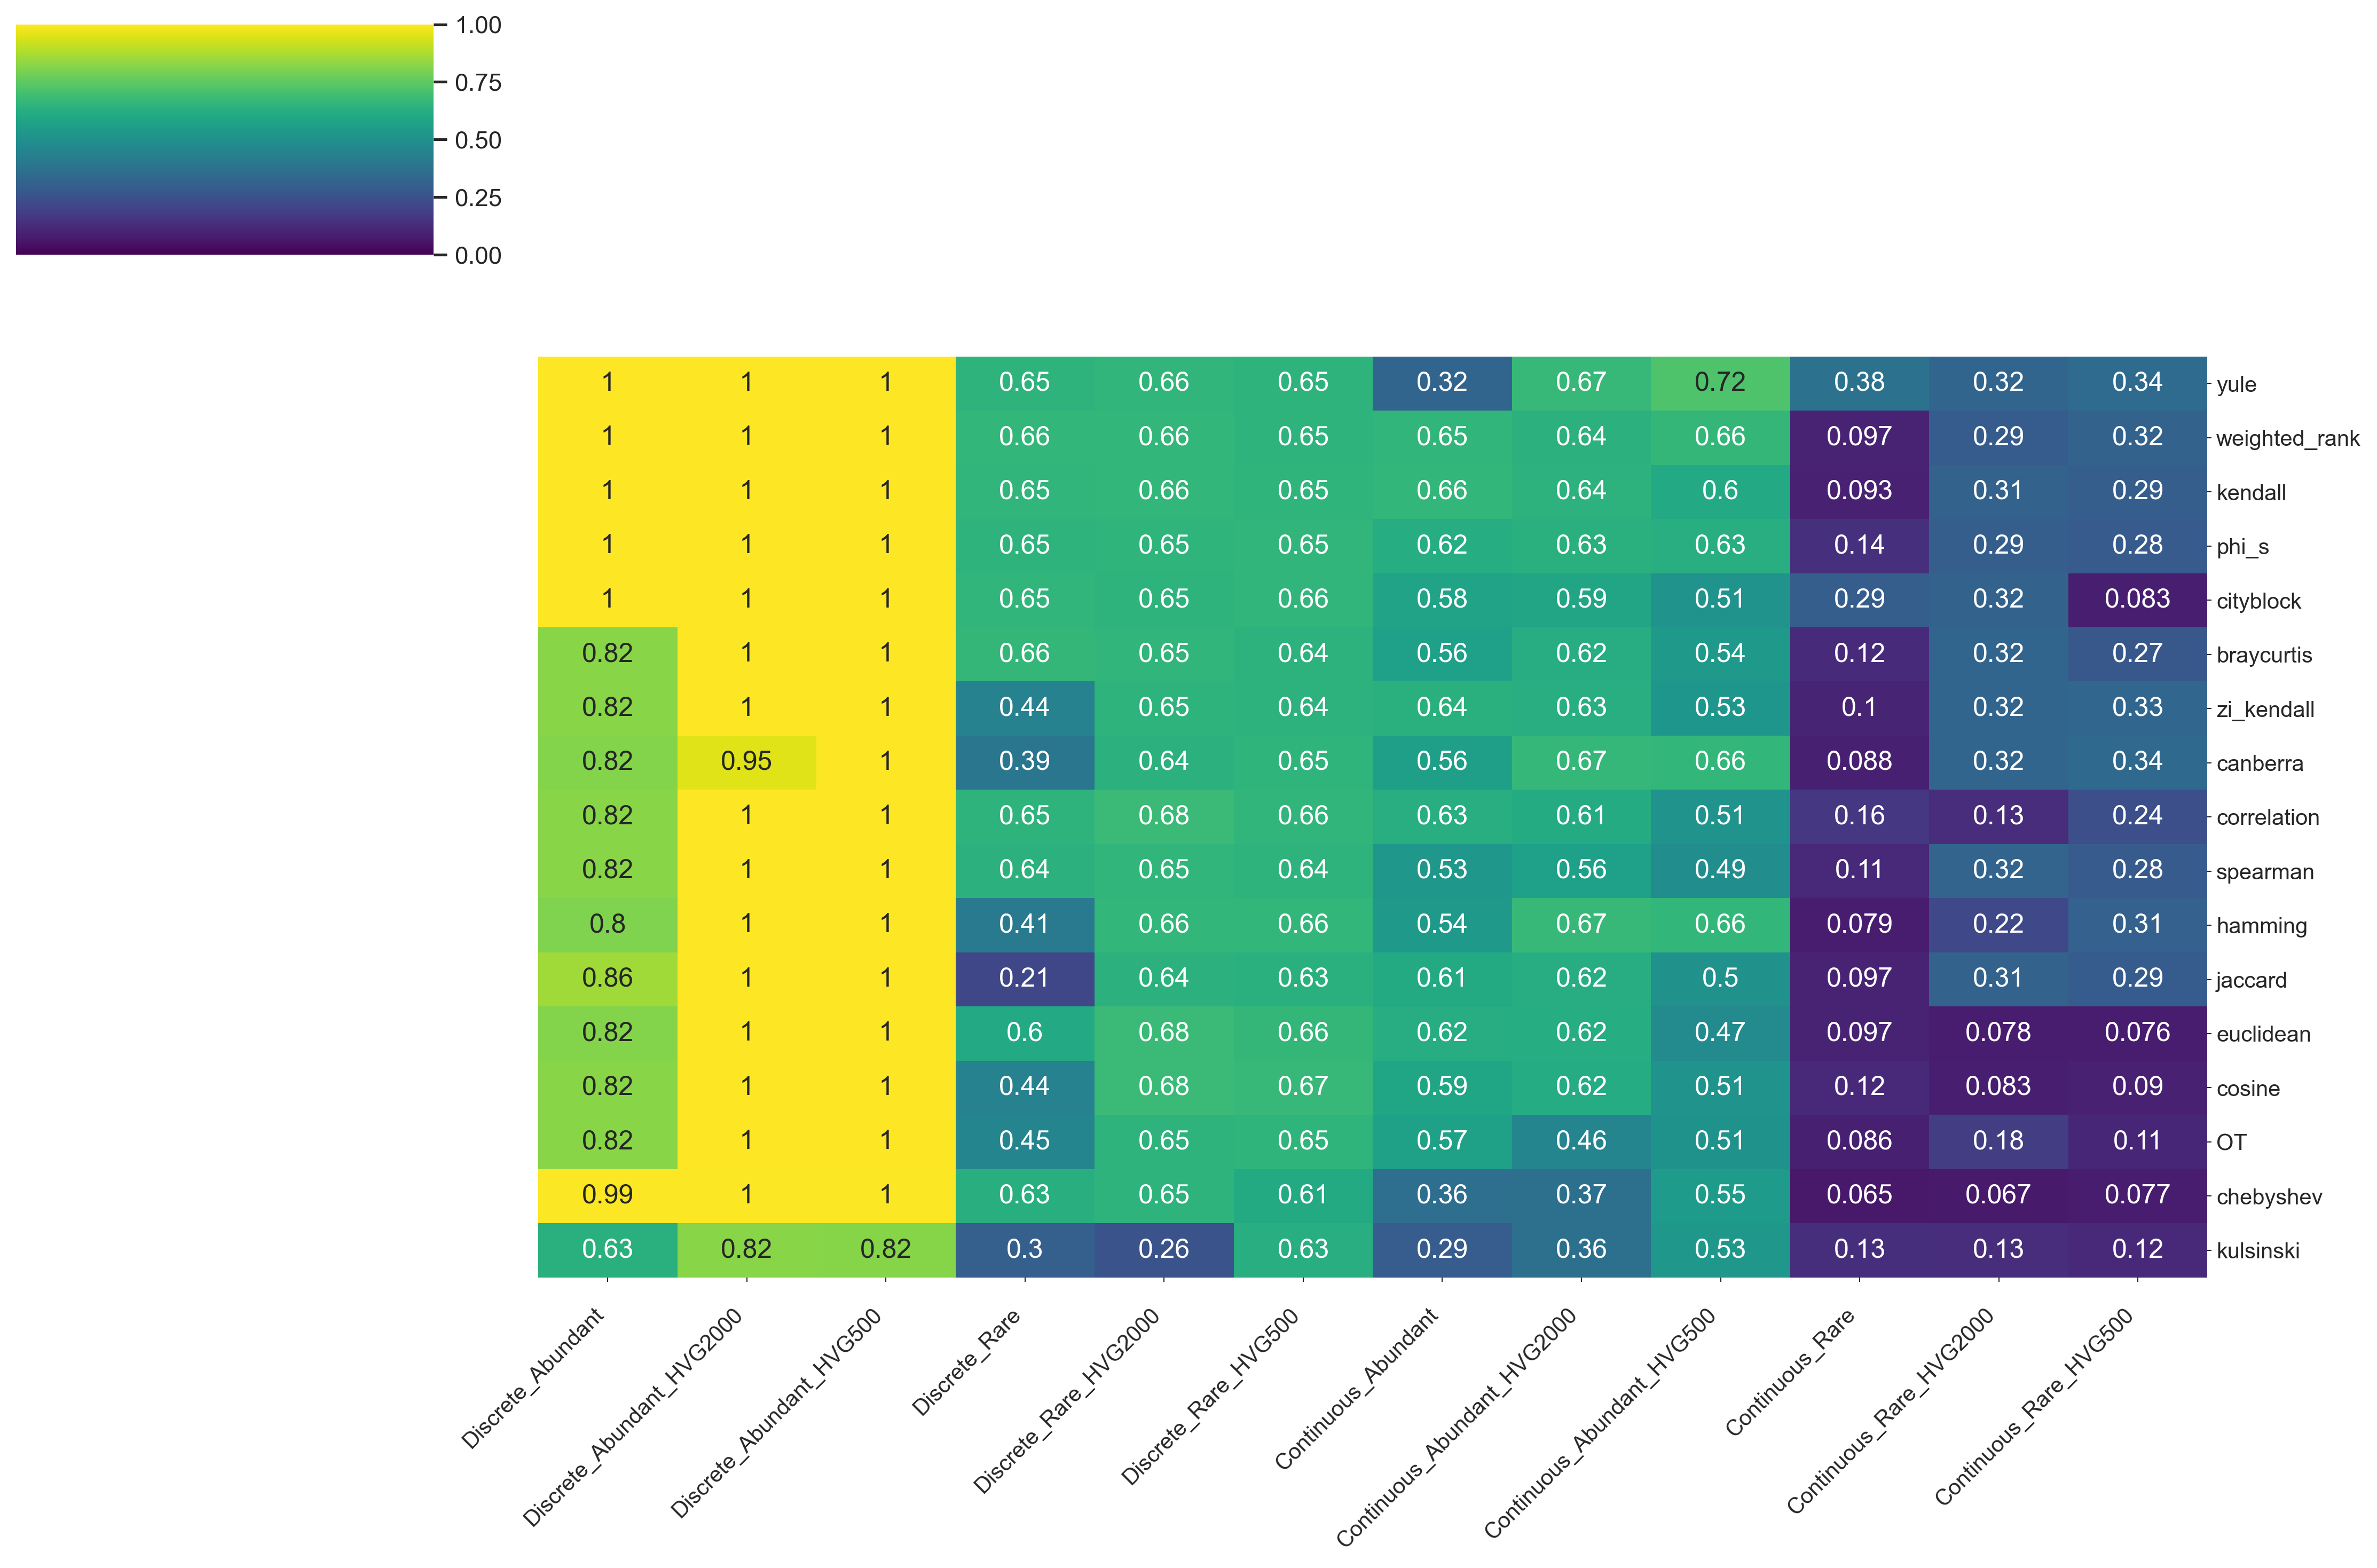

In [58]:
heat_df = k30_df.drop(labels = ['Evaluation_Metric', 'Data_Structure', 'Population_Balance', 'Condition', 'Property', 'k_value'], axis = 1).set_index('Metric')

heat_df = heat_df.pivot(columns='Dataset', values='Performance').reindex(columns=all_datasets)

heat_df['metric_avg'] = np.mean(heat_df.values, axis=1)
heat_df = heat_df.sort_values(by=['metric_avg'], ascending=False)
heat_df['metric'] = heat_df.index

heatmap = Heatmap(heat_df,chart_columns=all_datasets,
                  row_index='metric',
                  cmap=base_scale, 
                  vmin=0, vmax=1, 
                  annot = True,
                  cluster_rows=False, cluster_cols=False, 
                 config=heatmap_config)
ax = heatmap.plot()
ax.ax_heatmap.tick_params(axis='x', which='major', pad=10)
if save is True:
    plt.savefig(f'{fig_dir}Figure_Sup11B.png',  bbox_inches = 'tight')
plt.show()